In [111]:
!nvidia-smi

Mon Jul 21 23:43:29 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:B2:00.0 Off |                    0 |
| N/A   29C    P0              57W / 300W |    407MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# !pip install qiskit qiskit-ibm-runtime rdkit pandas numpy qiskit_aer pylatexenc

---

In [3]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator

In [4]:
from IPython.display import display
from collections import Counter
from typing import List, Union
import itertools
import multiprocessing
import pandas as pd
import numpy as np
import random
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

---

In [403]:
class MoleculeQuantumStateGenerator():
    def __init__(self, heavy_atom_size=5, ncpus=4, sanitize_method="strict", stereo_chiral=True):
        self.size = heavy_atom_size
        self.effective_numbers = list(range(heavy_atom_size))
        self.ncpus = ncpus
        self.atom_type_to_idx = {"C": 1, "O":2, "N": 3} # only supports C, O, N atoms now.
        self.bond_type_to_idx = {Chem.rdchem.BondType.SINGLE: 1, Chem.rdchem.BondType.DOUBLE: 2, Chem.rdchem.BondType.TRIPLE: 3}
        self.idx_to_atom_type = {1: "C", 2: "O", 3: "N"}
        self.idx_to_bond_type = {1: Chem.rdchem.BondType.SINGLE, 2: Chem.rdchem.BondType.DOUBLE, 3: Chem.rdchem.BondType.TRIPLE}
        self.qubits_per_type_atom = int(np.ceil(np.log2(len(self.atom_type_to_idx) + 1))) # How many qubits required for describing the quantum state of atom type
        self.qubits_per_type_bond = int(np.ceil(np.log2(len(self.bond_type_to_idx) + 1))) # How many qubits required for describing the quantum state of bond type
        self.n_qubits = int(self.size * self.qubits_per_type_atom + self.size * (self.size-1) / 2 * self.qubits_per_type_bond)
        self.sanitize_method = sanitize_method
        self.atom_valence_dict = {"C":4, "N":3, "O":2}
        self.stereo_chiral = stereo_chiral

    def decimal_to_binary(self, x, padding_length=2):
        """
        Parameters:
        x (int): The decimal value.

        Returns:
        str: A binary bit string.
        """
        bit = "0"*(padding_length-1) + bin(x)[2:]
        return bit[-padding_length:] # -2 means we only take 4 possible states

    def SmilesToConnectivity(self, smiles):
        """
        Generate a molecular graph from a SMILES string.

        Parameters:
        smiles (str): The SMILES string representing the molecule.

        Returns:
        tuple: A tuple containing the node vector (np.ndarray) and the adjacency matrix (np.ndarray).
        """
        node_vector = np.zeros(self.size)
        adjacency_matrix = np.zeros((self.size, self.size))
        mol = Chem.MolFromSmiles(smiles)
        Chem.Kekulize(mol)
        for atom in mol.GetAtoms():
            idx = atom.GetIdx()
            atom_type = atom.GetSymbol()
            node_vector[idx] = self.atom_type_to_idx[atom_type]
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            adjacency_matrix[i][j] = self.bond_type_to_idx[bond.GetBondType()]
            adjacency_matrix[j][i] = self.bond_type_to_idx[bond.GetBondType()]
        return node_vector, adjacency_matrix

    def _rank_list(self, lst):
        sorted_list = sorted(enumerate(lst), key=lambda x: x[1])
        rank = [0] * len(lst)
        for i, (original_index, _) in enumerate(sorted_list):
            rank[original_index] = i + 1
        return rank

    def _can_sort_with_even_swaps(self, list1, list2):
        def count_inversions(lst):
            inversions = 0
            for i in range(len(lst)):
                for j in range(i + 1, len(lst)):
                    if lst[i] > lst[j]:
                        inversions += 1
            return inversions
        inversions_list1 = count_inversions(list1)
        inversions_list2 = count_inversions(list2)
        return (inversions_list1 - inversions_list2) % 2 == 0

    def _set_chiral_atom(self, mol):
        """ Based on the atom-mapping and CIP information to determine the R/S chirality. """
        for atom in mol.GetAtoms():
            if atom.GetPropsAsDict(True, False).get("_ChiralityPossible", 0):
                atom_map_list = [int(neighbor.GetProp('molAtomMapNumber')) for neighbor in atom.GetNeighbors()]
                CIP_list = [int(neighbor.GetProp('_CIPRank')) for neighbor in atom.GetNeighbors()]
                chiral_tag = self._can_sort_with_even_swaps(self._rank_list(atom_map_list), self._rank_list(CIP_list))
                if chiral_tag:
                    atom.SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW)
                else:
                    atom.SetChiralTag(Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW)

    def _determine_bond_stereo(self, bond):
        begin_atom = bond.GetBeginAtom()
        begin_atom_map_number = int(begin_atom.GetProp('molAtomMapNumber'))
        end_atom = bond.GetEndAtom()
        end_atom_map_number = int(end_atom.GetProp('molAtomMapNumber'))
        begin_atom_neighbor_map = [int(a.GetProp('molAtomMapNumber')) for a in begin_atom.GetNeighbors()]
        begin_atom_neighbor_map.remove(end_atom_map_number)
        end_atom_neighbor_map = [int(a.GetProp('molAtomMapNumber')) for a in end_atom.GetNeighbors()]
        end_atom_neighbor_map.remove(begin_atom_map_number)
        if (len(begin_atom_neighbor_map) == 1) and (len(end_atom_neighbor_map) == 1):
            if abs(begin_atom_neighbor_map[0] - begin_atom_map_number) == abs(end_atom_neighbor_map[0] - end_atom_map_number):
                bond.SetStereo(Chem.rdchem.BondStereo.STEREOZ)
            else:
                bond.SetStereo(Chem.rdchem.BondStereo.STEREOE)
        else:
            begin_CIP_list = [int(neighbor.GetProp('_CIPRank')) for neighbor in begin_atom.GetNeighbors()
                            if int(neighbor.GetProp('molAtomMapNumber')) != end_atom_map_number]
            end_CIP_list = [int(neighbor.GetProp('_CIPRank')) for neighbor in end_atom.GetNeighbors()
                            if int(neighbor.GetProp('molAtomMapNumber')) != begin_atom_map_number]
            if self._can_sort_with_even_swaps(self._rank_list(begin_atom_neighbor_map), self._rank_list(begin_CIP_list)) == \
                self._can_sort_with_even_swaps(self._rank_list(end_atom_neighbor_map), self._rank_list(end_CIP_list)):
                bond.SetStereo(Chem.rdchem.BondStereo.STEREOZ)
            else:
                bond.SetStereo(Chem.rdchem.BondStereo.STEREOE)
        return

    def _set_stereo_bond(self, mol):
        Chem.FindPotentialStereoBonds(mol,cleanIt=True)
        for bond in mol.GetBonds():
            if bond.GetStereo() == Chem.rdchem.BondStereo.STEREOANY:
                self._determine_bond_stereo(bond)
        return

    def ConnectivityToSmiles(self, node_vector, adjacency_matrix):
        """
        Generate a SMILES string from the molecular graph.

        Returns:
        str: The SMILES string representing the molecule.
        """
        mol = Chem.RWMol()
        mapping_num_2_molIdx = {}
        for i, atom_type_idx in enumerate(node_vector):
            if atom_type_idx == 0:
                continue
            a = Chem.Atom(self.idx_to_atom_type[atom_type_idx])
            a.SetAtomMapNum(i+1)
            molIdx = mol.AddAtom(a)
            mapping_num_2_molIdx.update({i: molIdx})
        # add bonds between adjacent atoms, only traverse half the matrix
        for ix, row in enumerate(adjacency_matrix):
            for iy_, bond_type_idx in enumerate(row[ix+1:]):
                iy = ix + iy_ + 1
                if bond_type_idx == 0:
                    continue
                else:
                    bond_type = self.idx_to_bond_type[bond_type_idx]
                    try:
                        mol.AddBond(mapping_num_2_molIdx[ix], mapping_num_2_molIdx[iy], bond_type)
                    except:
                        return None
        mol = mol.GetMol()
        if self.sanitize_method == "strict":
            try:
                Chem.SanitizeMol(mol)
            except:
                return None
        elif self.sanitize_method == "soft":
            try:
                Chem.SanitizeMol(mol)
            except:
                try:
                    for atom in mol.GetAtoms():
                        bond_count = int(sum([bond.GetBondTypeAsDouble() for bond in atom.GetBonds()]))
                        if atom.GetSymbol() == "O" and bond_count >= 3:
                            atom.SetFormalCharge(bond_count - 2)
                        elif atom.GetSymbol() == "N" and bond_count >= 4:
                            atom.SetFormalCharge(bond_count - 3)
                        elif atom.GetSymbol() == "c" and bond_count >= 5:
                            atom.SetFormalCharge(bond_count - 4)
                    Chem.SanitizeMol(mol)
                except:
                    return None

        Chem.AssignStereochemistry(mol, flagPossibleStereoCenters=True)
        if self.stereo_chiral:
            self._set_chiral_atom(mol)
            self._set_stereo_bond(mol)
        for atom in mol.GetAtoms():
            atom.SetAtomMapNum(0)
        return Chem.MolToSmiles(mol, canonical=True)

    def ConnectivityToQuantumState(self, node_vector, adjacency_matrix):
        """
        Generate the quantum state (bit vector) based on the molecular connectivity.
        The preceding bits represent the atom type, and the subsequent bits represent the connectivity.

        Returns:
        np.ndarray: computational quantum state.
        """
        quantum_state = ""
        for atom_idx in node_vector:
            quantum_state += self.decimal_to_binary(int(atom_idx), padding_length=self.qubits_per_type_atom)
        for ix, row in enumerate(adjacency_matrix):
            for bond_type_idx in row[ix+1:]:
                quantum_state += self.decimal_to_binary(int(bond_type_idx), padding_length=self.qubits_per_type_bond)
        return quantum_state

    def QuantumStateToConnectivity(self, quantum_state):
        node_state = quantum_state[:2*self.size]
        bond_state = quantum_state[2*self.size:]
        node_vector = np.zeros(self.size)
        adjacency_matrix = np.zeros((self.size, self.size))
        for i in range(0, len(node_state), 2):
            node_vector[i//2] = int(node_state[i:i+2], 2)
        row = 0
        for i in range(0, len(bond_state), 2):
            idx = i // 2
            if idx == (2*(self.size-1) - (row+1) + 1) * (row+1) / 2:
                row += 1
            column = int(idx - (2*(self.size-1) - row + 1) * row / 2) + row + 1
            bond_type_idx = int(bond_state[i:i+2], 2)
            adjacency_matrix[row][column] = bond_type_idx
            adjacency_matrix[column][row] = bond_type_idx
        return node_vector, adjacency_matrix

    def QuantumStateToSmiles(self, quantum_state):
        return self.ConnectivityToSmiles(*self.QuantumStateToConnectivity(quantum_state))

    def QuantumStateToStateVector(self, quantum_state):
        stat_vector = np.zeros(2**self.n_qubits)
        decimal = int(quantum_state, 2)
        stat_vector[-1-decimal] = 1
        return stat_vector

    def QuantumStateToDecimal(self, quantum_state):
        decimal = int(quantum_state, 2)
        return decimal

    def post_process_quantum_state(self, result_state: str, reverse=True):
        """
        Reverse the qiskit outcome state and change the order to meet the definition of node vector and adjacency matrix.

        :param result_state: computational state derived from qiskit measurement outcomes
        :return: str of post-processed quantum state
        """
        assert len(result_state) == self.size*(self.size+1)
        if reverse:
            result_state = result_state[::-1]
        quantum_state = ""
        for i in range(self.size):
            atom_start_idx = i*2 + i*(i-1)
            quantum_state += result_state[atom_start_idx:atom_start_idx+2]
        for i in range(1, self.size):
            for a_k, j in enumerate(range(i, self.size)):
                bond_start_idx = (i+1)*2 + 2*a_k + j*(j-1) + (i-1)*2
                quantum_state += result_state[bond_start_idx:bond_start_idx+2]
        return quantum_state

    def generate_permutations(self, k):
        """
        Generate all possible permutations of k elements from the given list of elements.

        :param k: Number of elements to choose for permutations
        :return: List of permutations
        """
        return list(itertools.permutations(self.effective_numbers, k))

    def enumerate_all_quantum_states(self, smiles):
        """
        Generate all possible quantum states representing the given molecule SMILES.

        :return: List of quantum states (str)
        """
        node_vector, adjacency_matrix = self.SmilesToConnectivity(smiles)
        all_permutation_index = self.generate_permutations(np.count_nonzero(node_vector))
        args = [(self, node_vector, adjacency_matrix, new_index) for new_index in all_permutation_index]
        with multiprocessing.Pool(processes=self.ncpus) as pool:
            all_quantum_states = pool.starmap(subfunction_generate_state, args)

        return list(set(all_quantum_states))

    def permutate_connectivity(self, node_vector, adjacency_matrix, new_index):
        mapping_dict = {old: new for old, new in enumerate(new_index)}
        new_node_vector = np.zeros(self.size)
        new_adjacency_matrix = np.zeros((self.size, self.size))
        # atom
        for old, new in mapping_dict.items():
            new_node_vector[new] = node_vector[old]
        # bond
        for ix, row in enumerate(adjacency_matrix):
            for iy_, bond_type_idx in enumerate(row[ix+1:]):
                if not bond_type_idx:
                    continue
                iy = ix + iy_ + 1
                ix_new = mapping_dict[ix]
                iy_new = mapping_dict[iy]
                new_adjacency_matrix[ix_new][iy_new] = bond_type_idx
                new_adjacency_matrix[iy_new][ix_new] = bond_type_idx
        return new_node_vector, new_adjacency_matrix

    def generate_valid_mask(self, data: pd.DataFrame):
        """
        :return: binary valid quantum states mask (np.ndarray)
        """
        valid_state_vector_mask = np.zeros(2**self.n_qubits)
        for decimal_index in set(data["decimal_index"]):
            valid_state_vector_mask[int(decimal_index)] = 1
        return valid_state_vector_mask

In [414]:
def draw_top_molecules(smiles_dict, top_n=10, mols_per_row=5, mol_size=(300, 300)):
    """
    Draw the top N molecules with highest frequency from SMILES dictionary
    
    Parameters:
    - smiles_dict: Dictionary containing SMILES strings and their frequencies
    - top_n: Number of molecules to display, default is 10
    - mols_per_row: Number of molecules per row, default is 5
    - mol_size: Size of each molecule image, default is (300, 300)
    """
    
    filtered_dict = {k: v for k, v in smiles_dict.items() if k is not None}
    sorted_smiles = sorted(filtered_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    molecules = []
    legends = []
    
    for smiles, count in sorted_smiles:
        mol = Chem.MolFromSmiles(smiles)
        

        from rdkit.Chem import rdDepictor
        rdDepictor.Compute2DCoords(mol)
        
        molecules.append(mol)
        legends.append(f"{smiles}\nCount: {count}")

    drawer_opts = rdMolDraw2D.MolDrawOptions()
    drawer_opts.addStereoAnnotation = True 
    drawer_opts.addAtomIndices = False     
    drawer_opts.bondLineWidth = 2           
    drawer_opts.multipleBondOffset = 0.15  
    
    img = Draw.MolsToGridImage(
        molecules, 
        molsPerRow=mols_per_row,
        subImgSize=mol_size,
        legends=legends,
        useSVG=True,
        drawOptions=drawer_opts,
    )
    display(img)

---

In [442]:
num_heavy_atom = 3
temperature = 0.2
chemistry_constraint = True
# num_qubits = 4 + (num_heavy_atom-1) * 2
# num_clbits = num_heavy_atom * (num_heavy_atom + 1)
length_all_weight_vector = int(8 + (num_heavy_atom - 2)*(num_heavy_atom + 3) * 3 / 2)
num_sample = 1000
# random_seed = 7
# random.seed(0)

In [443]:
all_weight_vector = np.array([random.random() for _ in range(length_all_weight_vector)])
if chemistry_constraint and (num_heavy_atom>=3):
    used_part = 8
    for heavy_idx in range(3, num_heavy_atom+1):
        used_part += 3 # atom type weight vector
        num_fixed = heavy_idx-1
        num_flexible = 2*num_fixed
        bond_type_fixed_part = all_weight_vector[used_part: used_part+num_fixed]

        bond_type_fixed_part /= temperature
        exps = np.exp(bond_type_fixed_part)
        bond_type_fixed_part_tmp = exps / np.sum(exps)

        all_weight_vector[used_part: used_part+num_fixed] = bond_type_fixed_part_tmp
        bond_type_flexible_part = all_weight_vector[used_part+num_fixed: used_part+num_fixed+num_flexible]
        bond_type_flexible_part *= 0.5
        bond_type_flexible_part += np.array([0, 0.5]*(heavy_idx-1))
        all_weight_vector[used_part+num_fixed: used_part+num_fixed+num_flexible] = bond_type_flexible_part
        used_part += num_fixed + num_flexible

In [444]:
all_weight_vector*np.pi

array([3.08751163, 2.54537252, 2.83423792, 0.97435733, 2.29283406,
       2.82378376, 2.1487989 , 1.48328009, 0.31636218, 1.36399105,
       1.91915803, 1.36157854, 1.78001411, 0.7492852 , 2.93002198,
       0.40918036, 2.83533108])

---

In [445]:
import cudaq
import numpy as np

In [446]:
# cudaq.set_target('qpp-cpu')
cudaq.set_target('nvidia')
# cudaq.set_target('tensornet')
# cudaq.set_target('tensornet-mps')

In [447]:
@cudaq.kernel
def QMG_kernel(weight_vector: list[float]):
    # qubits 容器
    q = cudaq.qvector(6)
    # 儲存 measure 結果
    storage_qubits = cudaq.qvector(12)

    # atom1 and atom2 quantum circuit
    ry(np.pi * weight_vector[0], q[0])
    x(q[1])
    ry(np.pi * weight_vector[2], q[2])
    ry(np.pi * weight_vector[4], q[3])
    cx(q[0], q[1])
    cry(np.pi * weight_vector[3], q[1], q[2])
    cx(q[2], q[3])
    cry(np.pi * weight_vector[1], q[0], q[1])
    cx(q[1], q[2])
    cry(np.pi * weight_vector[5], q[2], q[3])

    # 量測 atom1 並將結果複製到 storage_qubits[0:2]
    atom1 = mz(q[:2])
    if atom1[0] == 1:
        x(storage_qubits[0])
    if atom1[1] == 1:
        x(storage_qubits[1])
    # 量測 atom2 並將結果複製到 storage_qubits[2:4]
    atom2 = mz(q[2:4])
    if atom2[0] == 1:
        x(storage_qubits[2])
    if atom2[1] == 1:
        x(storage_qubits[3])

    # 建立 bond1_2，只有在 atom2 不為 00 的狀況下，才會生成 bond0-1
    atom2_exists = not (atom2[0] == 0 and atom2[1] == 0)
    if atom2_exists:
        ry(np.pi * weight_vector[6], q[4])
        x(q[5])
        cx(q[4], q[5])
        cry(np.pi * weight_vector[7], q[4], q[5])
        # 量測 bond1_2，並將結果複製到 storage_qubits[4:6]
        bond1_2 = mz(q[4:6])
        if bond1_2[0] == 1:
            x(storage_qubits[4])
        if bond1_2[1] == 1:
            x(storage_qubits[5])

        # reset qubits 容器
        reset(q[:])

        # atom3 quantum circuit
        ry(np.pi * weight_vector[6], q[0])
        ry(np.pi * weight_vector[7], q[1])
        cry(np.pi * weight_vector[8], q[0], q[1])
        # 量測 atom3 並將結果複製到 storage_qubits[6:8]
        atom3 = mz(q[0:2])
        if atom3[0] == 1:
            x(storage_qubits[6])
        if atom3[1] == 1:
            x(storage_qubits[7])
            
        atom3_exists = not (atom3[0] == 0 and atom3[1] == 0)    
        if atom3_exists:
            ry(np.pi * weight_vector[9], q[3])
            ry(np.pi * weight_vector[10], q[5])
            cry(np.pi * weight_vector[11], q[3], q[2])
            cry(np.pi * weight_vector[12], q[2], q[3])
            cry(np.pi * weight_vector[13], q[5], q[4])
            cry(np.pi * weight_vector[14], q[4], q[5])
            # 量測 bond3_1，並將結果複製到 storage_qubits[8:10]
            bond3_1 = mz(q[2:4])
            if bond3_1[0] == 1:
                x(storage_qubits[8])
            if bond3_1[1] == 1:
                x(storage_qubits[9])
            # 量測 bond3_2，並將結果複製到 storage_qubits[10:12]
            bond3_2 = mz(q[4:6])
            if (bond3_2[1] == 0):
                x(q[5])
                bond3_2_1 = mz(q[4:6])
                if bond3_2_1[0] == 1:
                    x(storage_qubits[10])
                if bond3_2_1[1] == 1:
                    x(storage_qubits[11])
            else:
                if bond3_2[0] == 1:
                    x(storage_qubits[10])
                if bond3_2[1] == 1:
                    x(storage_qubits[11])                
    
    integrated_result = mz(storage_qubits)

{'CN=O': 1, 'C1=NC1': 1, None: 103, 'N#CN': 18, 'C': 1, 'C1NN1': 2, 'ONO': 2, 'NON': 1, 'O': 1, 'NNN': 1, 'OOO': 1, 'CO': 1, 'N=NN': 1, 'NN': 1, '[nH]1[nH]o1': 4, 'CNO': 2, 'NCO': 6, 'NCN': 7, 'N#CO': 8, 'C1N=N1': 2, 'C1CN1': 2, 'NO': 2, 'CC#N': 5, 'C1NO1': 1, 'N=O': 4, 'CCN': 5, 'N': 745, 'C1=NO1': 1, 'C1=NN1': 9, 'N=CN': 18, 'NNO': 6, 'O=NO': 2, 'N#[N+][O-]': 1, 'N=CO': 14, 'C=N': 6, 'CN': 1, 'NN=O': 7, 'CC=N': 4, 'C#N': 3}
Validity: 89.70%
Uniqueness: 4.24%


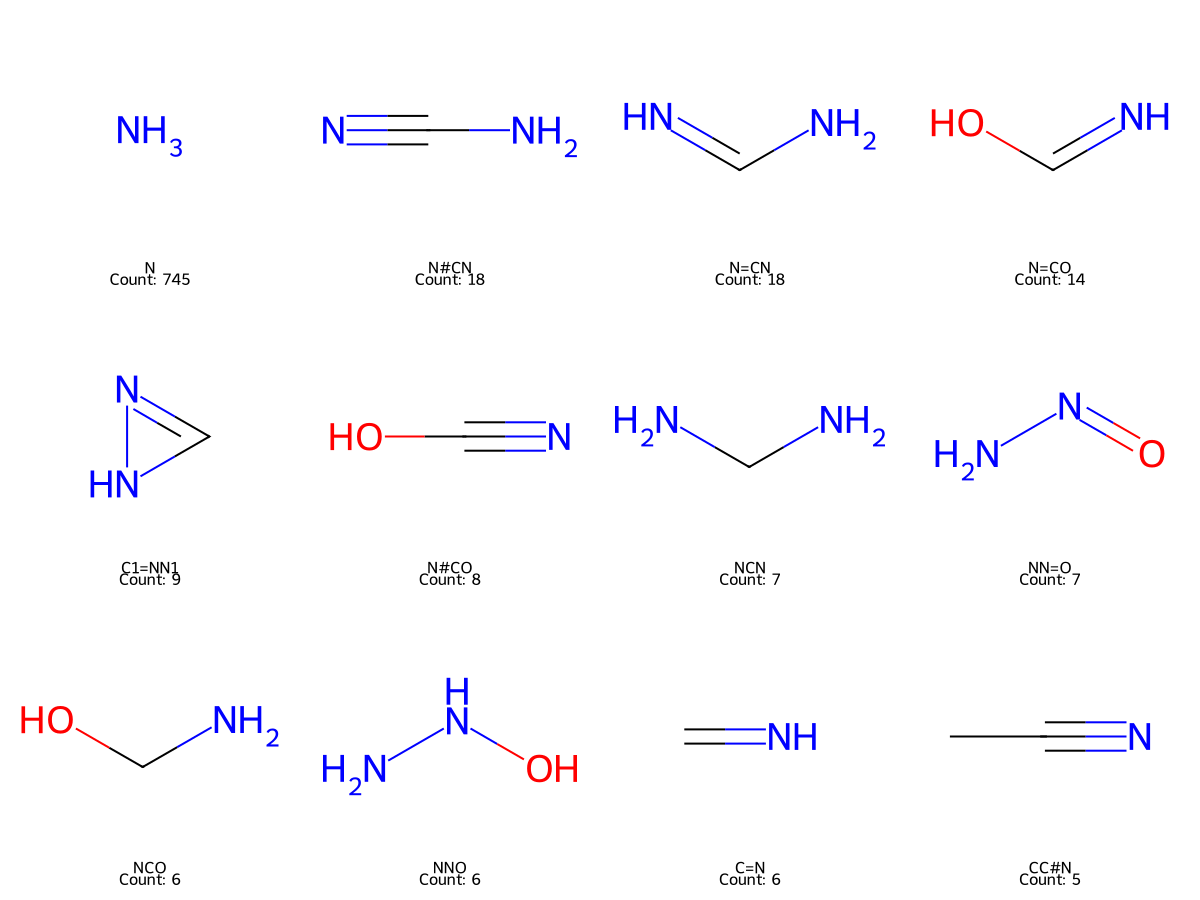

In [448]:
weight_vector = all_weight_vector
result = cudaq.sample(QMG_kernel, weight_vector, shots_count=1000)

integrated_counts = result.get_register_counts('integrated_result')
# print("Integrated Counts:", integrated_counts)

data_generator = MoleculeQuantumStateGenerator(heavy_atom_size=num_heavy_atom, ncpus=1, sanitize_method="strict")

smiles_dict = {}
num_valid_molecule = 0
for key, value in integrated_counts.items():
    key = key[::-1]
    key = "".join(key.split())
    smiles = data_generator.QuantumStateToSmiles(data_generator.post_process_quantum_state(key))
    smiles_dict[smiles] = smiles_dict.get(smiles, 0) + value
    if smiles:
        num_valid_molecule += value
validity = (num_valid_molecule) / num_sample
uniqueness = (len(smiles_dict.keys()) - 1) / num_valid_molecule
smiles_dict, validity, uniqueness

print(smiles_dict)
print("Validity: {:.2f}%".format(validity*100))
print("Uniqueness: {:.2f}%".format(uniqueness*100))

draw_top_molecules(smiles_dict, top_n=12, mols_per_row=4)